In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e12/sample_submission.csv
/kaggle/input/playground-series-s5e12/train.csv
/kaggle/input/playground-series-s5e12/test.csv


# Load and Explore Data

In [19]:
# Load the datasets
train_df = pd.read_csv('/kaggle/input/playground-series-s5e12/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e12/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e12/sample_submission.csv')

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
print("\nSample Submission format:")
print(sample_submission.head())

Train dataset shape: (700000, 26)
Test dataset shape: (300000, 25)

Sample Submission format:
       id  diagnosed_diabetes
0  700000                   0
1  700001                   0
2  700002                   0
3  700003                   0
4  700004                   0


In [20]:
# Display first few rows of training data
print("Training Data:")
print(train_df.head())
print("\n" + "="*80 + "\n")
print("Training Data Info:")
print(train_df.info())
print("\n" + "="*80 + "\n")
print("Training Data Statistics:")
print(train_df.describe())

Training Data:
   id  age  alcohol_consumption_per_week  physical_activity_minutes_per_week  \
0   0   31                             1                                  45   
1   1   50                             2                                  73   
2   2   32                             3                                 158   
3   3   54                             3                                  77   
4   4   54                             1                                  55   

   diet_score  sleep_hours_per_day  screen_time_hours_per_day   bmi  \
0         7.7                  6.8                        6.1  33.4   
1         5.7                  6.5                        5.8  23.8   
2         8.5                  7.4                        9.1  24.1   
3         4.6                  7.0                        9.2  26.6   
4         5.7                  6.2                        5.1  28.8   

   waist_to_hip_ratio  systolic_bp  ...  gender  ethnicity  education_level  

In [21]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())
print("\n" + "="*80 + "\n")
print("Missing values in test data:")
print(test_df.isnull().sum())

Missing values in training data:
id                                    0
age                                   0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
smoking_status                        0
employment_status                     0
family_history_diabetes               0
hypertension_history                  0
cardiov

In [22]:
# Check target variable distribution
if 'diagnosed_diabetes' in train_df.columns:
    print("Target variable distribution:")
    print(train_df['diagnosed_diabetes'].value_counts())
    print("\nTarget variable percentage:")
    print(train_df['diagnosed_diabetes'].value_counts(normalize=True) * 100)

Target variable distribution:
diagnosed_diabetes
1.0    436307
0.0    263693
Name: count, dtype: int64

Target variable percentage:
diagnosed_diabetes
1.0    62.329571
0.0    37.670429
Name: proportion, dtype: float64


# Data Visualization

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


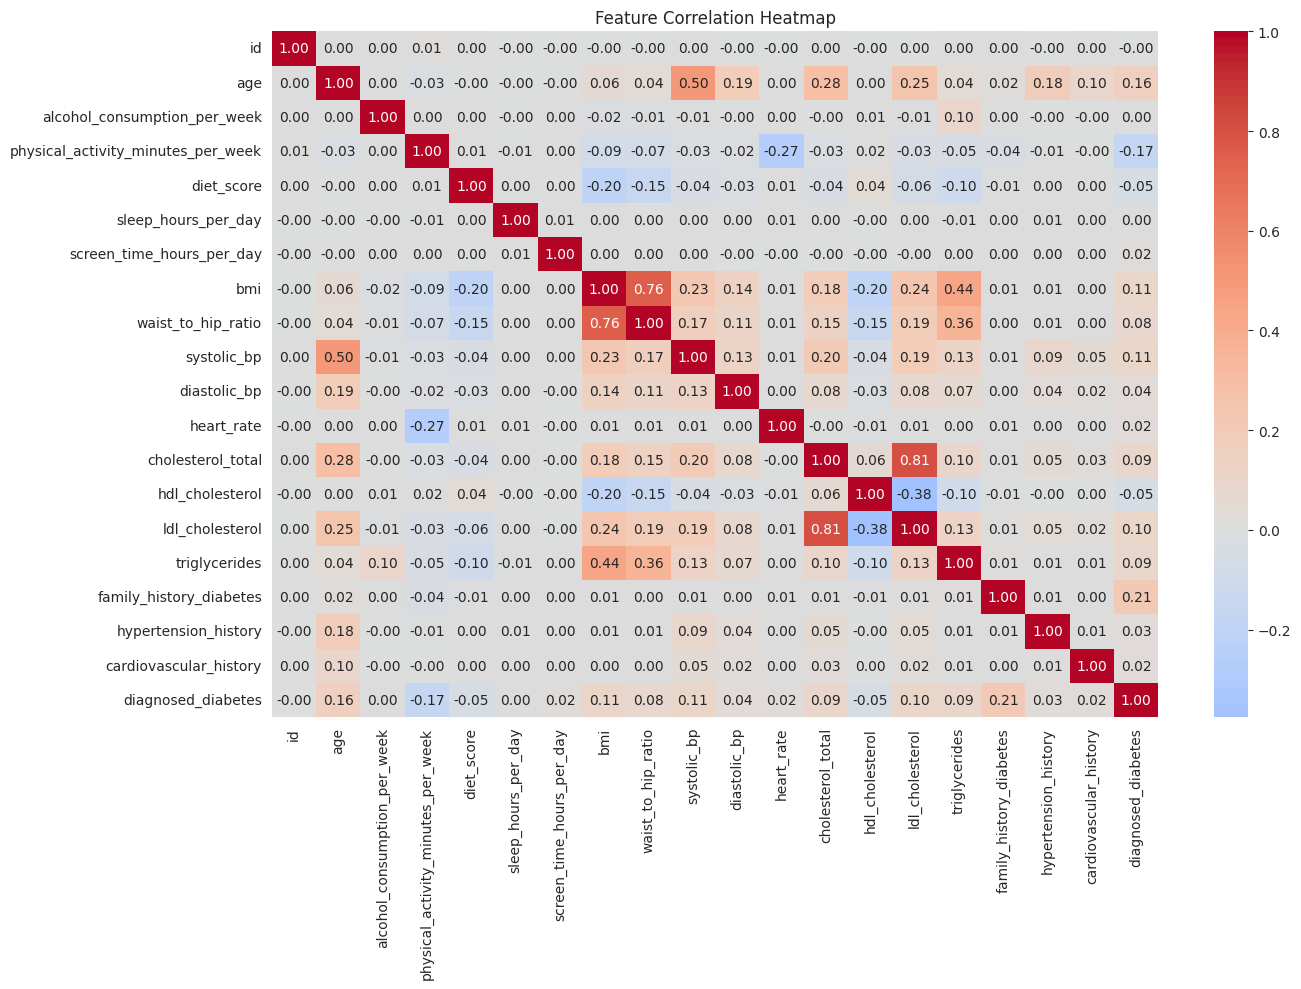

In [24]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
correlation = train_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Data Preprocessing

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
# The target variable is 'diagnosed_diabetes'
X = train_df.drop(['id', 'diagnosed_diabetes'], axis=1, errors='ignore')
y = train_df['diagnosed_diabetes'] if 'diagnosed_diabetes' in train_df.columns else None

# Store test ids for submission
test_ids = test_df['id'] if 'id' in test_df.columns else test_df.index
X_test = test_df.drop(['id'], axis=1, errors='ignore')

print("Features shape:", X.shape)
print("Target shape:", y.shape if y is not None else "Target not found")
print("Test features shape:", X_test.shape)
print("\nFeature columns:", list(X.columns))

Features shape: (700000, 24)
Target shape: (700000,)
Test features shape: (300000, 24)

Feature columns: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']


In [26]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)
print(f"\nTotal: {len(categorical_cols)} categorical, {len(numerical_cols)} numerical")

Categorical columns: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']
Numerical columns: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']

Total: 6 categorical, 18 numerical


In [27]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

# Create copies to avoid modifying original data
X_encoded = X.copy()
X_test_encoded = X_test.copy()

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined data to ensure consistency
    combined = pd.concat([X[col], X_test[col]], axis=0)
    le.fit(combined)
    
    X_encoded[col] = le.transform(X[col])
    X_test_encoded[col] = le.transform(X_test[col])
    label_encoders[col] = le
    
print("Categorical encoding completed!")
print(f"Encoded {len(categorical_cols)} categorical features")

Categorical encoding completed!
Encoded 6 categorical features


In [28]:
# Split data into train and validation sets (using encoded data)
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

Training set size: (560000, 24)
Validation set size: (140000, 24)


In [29]:
# Scale features (now all numerical after encoding)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_encoded)

print("Data scaling completed!")
print(f"Scaled data shape - Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}")

Data scaling completed!
Scaled data shape - Train: (560000, 24), Val: (140000, 24), Test: (300000, 24)


# Handle Class Imbalance

In [30]:
# Calculate class weights for imbalanced dataset
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class weights:", class_weight_dict)
print("\nThis will help the model pay more attention to the minority class")

Class weights: {0.0: 1.3273035827715995, 1.0: 0.8021865312881397}

This will help the model pay more attention to the minority class


# Model Training and Evaluation

In [33]:
# Import all required libraries for modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [34]:
# Dictionary to store models and their results (with class_weight for imbalanced data)
scale_pos_weight = (y_train == 0.0).sum() / (y_train == 1.0).sum()

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, 
                            scale_pos_weight=scale_pos_weight, 
                            eval_metric='logloss', n_jobs=-1)
}

results = {}
print(f"Total models to train: {len(models)}")
print(f"Models: {list(models.keys())}")

Total models to train: 4
Models: ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']


In [35]:
# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Training {name}...")
    print('='*80)
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val_scaled)
    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'predictions': y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_val, y_pred))
    print(f"\nConfusion Matrix:")
    print(confusion_matrix(y_val, y_pred))


Training Logistic Regression...
Accuracy: 0.6268
ROC AUC Score: 0.6947

Classification Report:
Accuracy: 0.6268
ROC AUC Score: 0.6947

Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.68      0.58     52739
         1.0       0.75      0.60      0.67     87261

    accuracy                           0.63    140000
   macro avg       0.63      0.64      0.62    140000
weighted avg       0.66      0.63      0.63    140000


Confusion Matrix:
[[35815 16924]
 [35318 51943]]

Training Random Forest...
              precision    recall  f1-score   support

         0.0       0.50      0.68      0.58     52739
         1.0       0.75      0.60      0.67     87261

    accuracy                           0.63    140000
   macro avg       0.63      0.64      0.62    140000
weighted avg       0.66      0.63      0.63    140000


Confusion Matrix:
[[35815 16924]
 [35318 51943]]

Training Random Forest...
Accuracy: 0.6638
ROC AUC Score: 0

In [36]:
# Compare model performance
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'ROC AUC': [results[m]['roc_auc'] for m in results.keys()]
})
comparison_df = comparison_df.sort_values('ROC AUC', ascending=False)
print(comparison_df.to_string(index=False))

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\n✓ Best Model: {best_model_name} with ROC AUC: {results[best_model_name]['roc_auc']:.4f}")


MODEL COMPARISON
              Model  Accuracy  ROC AUC
            XGBoost  0.653664 0.722297
  Gradient Boosting  0.672136 0.707285
Logistic Regression  0.626843 0.694718
      Random Forest  0.663757 0.693025

✓ Best Model: XGBoost with ROC AUC: 0.7223


# Generate Predictions on Test Data

In [37]:
# Generate predictions on test data using the best model
test_predictions_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print(f"Generated {len(test_predictions_proba)} predictions")
print(f"Prediction range: [{test_predictions_proba.min():.4f}, {test_predictions_proba.max():.4f}]")
print(f"Mean prediction: {test_predictions_proba.mean():.4f}")

Generated 300000 predictions
Prediction range: [0.0197, 0.9947]
Mean prediction: 0.5001


# Create Submission File

In [ ]:
# Create submission dataframe following the sample_submission format
submission = pd.DataFrame({
    'id': test_ids,
    'diagnosed_diabetes': test_predictions_proba
})

submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

print("Submission file preview:")
print(submission.head(10))
print(f"\nSubmission shape: {submission.shape}")
print(f"Columns: {list(submission.columns)}")

Submission file preview:
       id  diagnosed_diabetes
0  700000            0.356891
1  700001            0.539725
2  700002            0.760027
3  700003            0.297863
4  700004            0.889759
5  700005            0.481981
6  700006            0.549111
7  700007            0.924222
8  700008            0.451795
9  700009            0.675819

Submission shape: (300000, 2)
Columns: ['id', 'diagnosed_diabetes']
